# The following dataset is used: [Breast Cancer Dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset). The goal is to build a decision tree to detect breast cancer, with the model aiming to classify tumors as benign or malignant.

Empieza el projecto.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from yellowbrick.model_selection import RFECV


warnings.filterwarnings("ignore")

file = "https://raw.githubusercontent.com/Mafasamo/PortafolioML/refs/heads/main/Decision%20Tree/breast-cancer.csv"

raw_data = pd.read_csv(file)
raw_data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Preprocessing:

The total number of null values is checked, and the training set information is displayed.

In [ ]:
total_nulls = raw_data.isnull().sum().sum()
print("Total number of null values in the DataFrame:", total_nulls)

# Replace diagnosis values with binary labels
raw_data['diagnosis'].replace({"M": 1, "B": 0}, inplace=True)
target = raw_data[['diagnosis']].copy()
raw_data = raw_data.drop(["id", "diagnosis"], axis=1)
columns = raw_data.columns

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(raw_data, target, test_size=0.2, random_state=42, shuffle=True)
X_train.info()

Total number of null values in the DataFrame: 0
<class 'pandas.core.frame.DataFrame'>
Index: 455 entries, 68 to 102
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              455 non-null    float64
 1   texture_mean             455 non-null    float64
 2   perimeter_mean           455 non-null    float64
 3   area_mean                455 non-null    float64
 4   smoothness_mean          455 non-null    float64
 5   compactness_mean         455 non-null    float64
 6   concavity_mean           455 non-null    float64
 7   concave points_mean      455 non-null    float64
 8   symmetry_mean            455 non-null    float64
 9   fractal_dimension_mean   455 non-null    float64
 10  radius_se                455 non-null    float64
 11  texture_se               455 non-null    float64
 12  perimeter_se             455 non-null    float64
 13  area_se                  455 non-nul

Due to the difficulty that the ID3 algorithm has in working with continuous variables, data discretization will be necessary. The K-means clustering method will be used for this purpose. To determine the optimal $k$ for the K-means algorithm, the "Elbow curve" and "Silhouette score" methods will be applied.

*   Elbow curve: For each value of $k$ (number of clusters), the Inertia value of the dataset is calculated: $\text{Inertia} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$, where:

  *   $k$ is the number of clusters,
  *   $C_i$ is the set of points in cluster $i$,
  *   $||x - \mu_i||^2$ is the squared Euclidean distance between a point $x$ and its centroid $μ_i$.
<br>

   Then, Inertia values are plotted against different values of $k$. It can be observed that as the number of clusters increases, Inertia decreases. However, the reduction in Inertia becomes progressively smaller with each added cluster. The goal of this method is to find the $k$ where an increase in the number of clusters no longer results in a significant reduction in Inertia.
*   Silhouette score: The silhouette score of a point measures how similar it is to its own cluster compared to other clusters. For each point $i$ in the dataset, the silhouette score is calculated as follows: $s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$, where:
  *   $s(i)$ is the silhouette score of i,
  *   $b(i)$ is the average distance between point $i$ and other points in the same cluster,
  *   $a(i)$ is the average distance between point $i$ and points in the nearest cluster different from the one $i$ belongs to. <br>

  Next, the average silhouette score of the dataset is calculated: <br>
    *   $\text{Silhouette Score} = \frac{1}{N} \sum_{i=1}^{N} s(i)$
  
  The optimal number of clusters is chosen by maximizing the average silhouette score.

The "elbow curve" method is applied. If the results obtained from this method are inconclusive, the "silhouette score" method is then used.

The following example applies both methods to determine the optimal $k$ value for discretizing the feature "radius_worst".

Inertia K=1: 10509.32446614506
Inertia K=2: 3001.342781682906
Inertia K=3: 1671.9832727466312
Inertia K=4: 1044.794151707327
Inertia K=5: 703.5480010010334
Inertia K=6: 468.16926398690015
Inertia K=7: 350.428970794617
Inertia K=8: 321.2233106518632


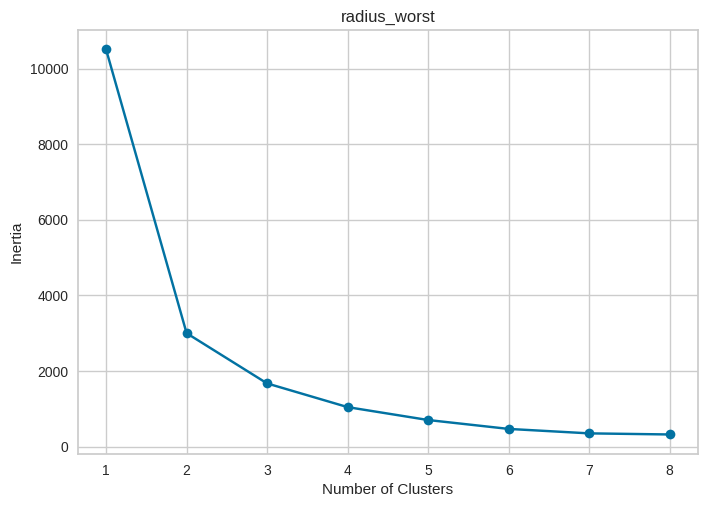

Number of clusters: 2
Silhouette score: 0.6756340036431641


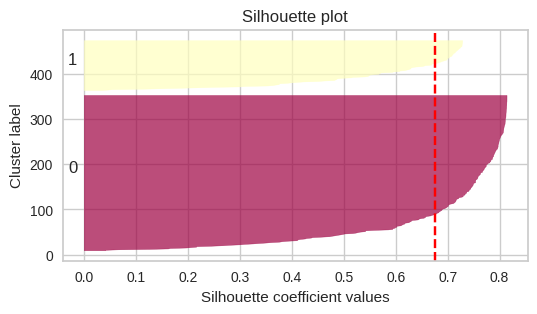

Number of clusters: 3
Silhouette score: 0.5517554069489327


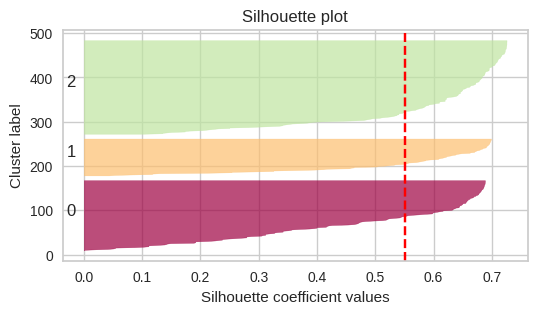

Number of clusters: 4
Silhouette score: 0.5402173996589429


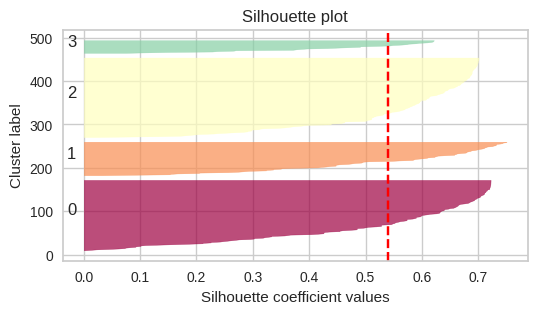

In [ ]:
# Select the column and reshape data
column_data = X_train["radius_worst"].values.reshape(-1, 1)

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")

# Fit KMeans with a range of cluster numbers
inertia_values = []
possible_clusters = range(1, 9)

for k in possible_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(column_data)
    inertia_values.append(kmeans.inertia_)

for k in possible_clusters:
    inertia = str(inertia_values[k-1])
    print("Inertia K=" + str(k) + ": " + inertia)

# Plot the Elbow curve
plt.plot(possible_clusters, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('radius_worst')
plt.show()

def plot_silhouette_analysis(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, labels)
    sample_silhouette_values = silhouette_samples(data, labels)

    fig, ax1 = plt.subplots(1, 1, figsize=(6, 3))

    # Silhouette plot
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    print("Number of clusters: " + str(n_clusters))
    print("Silhouette score: " + str(silhouette_avg))
    plt.show()

# Plot silhouette analysis for different numbers of clusters
for n_clusters in range(2, 5):
    plot_silhouette_analysis(column_data, n_clusters)

After running the "Elbow curve" method, it is observed that there are three strong candidates for the optimal $k$ value: 2, 3, and 4. Next, the "Silhouette score" method is applied using these three values.

The results obtained are as follows:
  *   k=2: Inertia = 3001.34, Silhouette Score = 0.67.
  *   k=3: Inertia = 1671.98, Silhouette Score = 0.55.
  *   k=4: Inertia = 1044.79, Silhouette Score = 0.54.

A comparison is made between k=2 and k=3, as well as between k=3 and k=4.
  *   Increasing the number of clusters from 2 to 3 results in a 44.29% reduction in Inertia and a 17.91% decrease in the Silhouette score.
  *   Increasing the number of clusters from 3 to 4 results in a 37.51% reduction in Inertia and a 1.82% decrease in the Silhouette score.

While the highest Silhouette score is obtained using two clusters, the reduction in Inertia when using three clusters is considerably high, so a cluster count of three is preferred over two.

When comparing $k$ = 3 and $k$ = 4, there is also a clear improvement in the Inertia value when using four clusters, while the Silhouette score decreases only slightly.

Evaluating the results from both methods, it is decided to use a cluster count of four for the "radius_worst" feature.

The same procedure is applied to the remaining features.

In [ ]:
clusters_per_feature  = [3,3,3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]
features_names = columns
clusters_per_feature_series = pd.Series(clusters_per_feature, index=features_names)

A function is defined to create a data transformer, where a KBinsDiscretizer is generated for each feature.

In [ ]:
def k_bins_discretizer(data, clusters_per_feature_series):
  transformers = []

  for column_name in columns:
    column = data[column_name]

    if column.dtype == 'float64':
      transformer_name = 'discretize_' + column_name.replace('_', '')
      transformer = (transformer_name,
                      KBinsDiscretizer(n_bins=clusters_per_feature_series[column_name], encode='ordinal', strategy='kmeans'),
                      [column_name])
      transformers.append(transformer)

  discretizer = ColumnTransformer(
  transformers=transformers,
  remainder='passthrough',
  verbose_feature_names_out=False,
  ).set_output(transform="pandas")

  discretizer.fit(data)
  return discretizer

Data discretization.

In [ ]:
discretizer = k_bins_discretizer(X_train, clusters_per_feature_series)

X_train_indexes = X_train.index
X_test_indexes = X_test.index

X_train = discretizer.transform(X_train)
X_test = discretizer.transform(X_test)

Data normalization.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train_indexes, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test_indexes, columns=X_test.columns)

RFECV is used along with an SVC classifier to reduce data dimensionality, iteratively removing the least important features through a Cross-Validation process until the optimal subset of features is found.

Number of selected features: 16


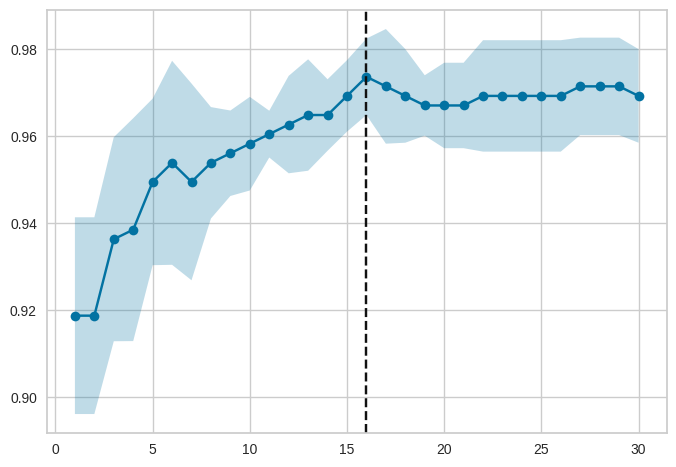

<Figure size 560x400 with 0 Axes>

In [ ]:
estimator = SVC(kernel='linear')

# Create the RFECV object and fit it to the training data
selector = RFECV(estimator, step=1, cv=5, scoring='accuracy')
selector.fit(X_train, y_train)

# Print the number of selected features
print("Number of selected features:", selector.n_features_)

# Plot
plt.figure(figsize=[5.6, 4])
plt.show()

In [ ]:
selected_feature_indices = selector.support_
selected_feature_names = X_train.columns[selected_feature_indices]

# Create a DataFrame with only the selected features
X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]
X_train.head(5)

,radius_mean,area_mean,concavity_mean,concave points_mean,radius_se,area_se,concave points_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst
68,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.333333,0.0,0.5,0.0,0.5,0.5,1.0,0.5,1.0
181,1.0,0.5,1.0,1.0,0.333333,0.5,0.5,0.333333,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0
63,0.0,0.0,0.0,0.0,0.333333,0.0,0.5,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
248,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.5
60,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5


## Model Building, Training, and Testing:

The ID3 algorithm uses information gain as a metric to select the best feature at each step of tree construction. The goal is to maximize information gain, which implies minimizing entropy in the resulting subsets after the split.

Entropy: Let $S$ be a set of examples, and $c$ a target function that takes values $c_0…c_n$:
$\text{Entropy(S)} = - \sum_{c_i \in C} P_{c_i} * log(P_{c_i})$, where:
*   $P_{c_i}$ is the proportion of examples $x \in S$ for which $f(x) = c_i$






In [ ]:
def entropy(feature):
    values, counts = np.unique(feature, return_counts=True)
    entropy_value= 0
    for i in range(len(values)):
        entropy_value -= (counts[i] / np.sum(counts)) * np.log2(counts[i] / np.sum(counts))
    return entropy_value

The Information Gain of a feature $A$ over a sample $S$ is defined as:
$\text{Information Gain(S,A)} = {Entropy(S)} - \sum_{v \in Val(A)} \frac {||S_v||}{S}$

In [ ]:
def information_gain(data, feature, global_entropy):
    values, counts = np.unique(data[feature], return_counts=True)
    instance_feature_entropy = 0
    for i in range(len(values)):
        instance_feature_entropy = instance_feature_entropy + (counts[i] / np.sum(counts)) * feature_entropy(data, feature, values[i])
    instance_feature_information_gain = global_entropy - instance_feature_entropy
    return instance_feature_information_gain

In [ ]:
def feature_entropy(data, feature, value):
    entropy_value = entropy(data.where(data[feature]==value).dropna()["Target"])
    return entropy_value

def most_common_value(target):
  return np.unique(target)[np.argmax(np.unique(target, return_counts=True)[1])]

most_common_value_target = most_common_value(y_train)
print(most_common_value_target)

0


ID3 algorithm:

In [ ]:
def id3_algorithm(data, target, features, min_samples_split, min_split_gain):
    most_common_value_target = most_common_value(target)

    # Base cases:

    # If the minimum number of samples is less than "min_samples_split":
    if len(data) < min_samples_split:
        return most_common_value_target

    # If the target column value is unique:
    elif len(target.value_counts()) <= 1:
        return target.iloc[0]

    # If there are no features left:
    elif len(features) == 0:
        return most_common_value_target

    else:
        data["Target"] = target
        # Calculate information gain for all features:
        features_gain = []
        global_entropy = entropy(target)

        for feature in features:
            features_gain.append(information_gain(data, feature, global_entropy))

        # Find the index of the feature with the highest information gain:
        best_feature_index = np.argmax(features_gain)

        # If no feature reaches the required minimum gain "min_split_gain":
        if features_gain[best_feature_index] < min_split_gain:
            return most_common_value_target

        # If at least one feature meets the required minimum gain "min_split_gain":
        else:
            # Select feature with the highest information gain:
            best_feature = features[best_feature_index]

            # Create root node:
            tree = {best_feature: {}}

            sub_features = [i for i in features if i != best_feature]
            for value in np.unique(data[best_feature]):
                sub_data = data.where(data[best_feature] == value).dropna()
                sub_data = sub_data.drop(columns=[best_feature])
                if len(sub_data) == 0:
                    tree[best_feature][value] = most_common_value_target
                else:
                    sub_target = sub_data.Target
                    sub_data = sub_data.iloc[:, :-1]
                    sub_tree = id3_algorithm(sub_data, sub_target, sub_features, min_samples_split, min_split_gain)
                    tree[best_feature][value] = sub_tree
            return tree

In [ ]:
def predict(features_list, tree, default=0):
    # Traverse the list of features
    for key in list(features_list.keys()):
        # For each feature, check if it is the root feature in the tree
        if key in list(tree.keys()):
            # Evaluate if there is a branch with the value "tree[key][features_list[key]]".
            # If not, return the default value (0, representing "B").
            try:
                result = tree[key][features_list[key]]
            except:
                return default

            # Check if it is a node or a leaf.
            # If it is a node, apply ID3 recursively with updated parameters.
            # If it is a leaf, return its value.
            if isinstance(result, dict):
                return predict(features_list, result)
            else:
                return result

def fit(df, target, min_samples_split, min_split_gain):
    features = df.columns.values.tolist()
    return id3_algorithm(df, target, features, min_samples_split, min_split_gain)

def get_prediction(df, tree):
    return df.apply(predict, axis=1, args=(tree, 0))

Next, various combinations of two hyperparameters, min_samples_split and min_split_gain, are used. The dataset is split into training and validation sets, and then iterated over possible values of these hyperparameters, training a model for each combination. For each model, accuracy on the validation set is evaluated, results are stored, and the best combination that maximizes accuracy is identified.

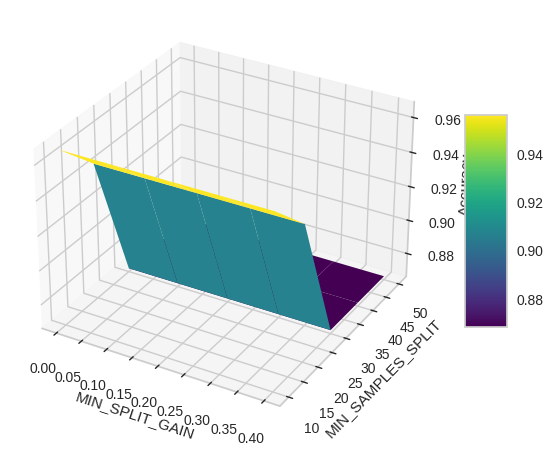

Best accuracy: 0.967032967032967
Best min_samples_split: 10
Best min_split_gain: 0.0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Define values for the hyperparameters to test
min_samples_split_values = [10, 20, 30, 40, 50]
min_split_gain_values = [0.0, 0.1, 0.2, 0.3, 0.4]

best_accuracy = 0
best_min_samples_split = 10
accuracies = []

# Use the validation set to evaluate hyperparameter combinations
for min_samples_split in min_samples_split_values:
    for min_split_gain in min_split_gain_values:
        X_val_copy = X_val.copy()  # Copy original data
        y_val_copy = y_val.copy()
        tree = fit(X_val_copy, y_val_copy, min_samples_split, min_split_gain)

        # Evaluate on the validation set
        y_pred_val = get_prediction(X_val, tree)
        accuracy_val = accuracy_score(y_val, y_pred_val)

        accuracies.append((min_samples_split, min_split_gain, accuracy_val))

        if accuracy_val == best_accuracy:
            if min_samples_split > best_min_samples_split:
                best_accuracy = accuracy_val
                best_min_samples_split = min_samples_split
                best_min_split_gain = min_split_gain

        if accuracy_val > best_accuracy:
            best_accuracy = accuracy_val
            best_min_samples_split = min_samples_split
            best_min_split_gain = min_split_gain

accuracies = np.array(accuracies)

# Generate a plot showing the model accuracy as a function of min_samples_split and min_split_gain
unique_min_split_gain = np.unique(accuracies[:, 1])
unique_min_samples_split = np.unique(accuracies[:, 0])

Z = np.zeros((len(unique_min_samples_split), len(unique_min_split_gain)))

for i, min_samples_split in enumerate(unique_min_samples_split):
    for j, min_split_gain in enumerate(unique_min_split_gain):
        match = accuracies[(accuracies[:, 0] == min_samples_split) & (accuracies[:, 1] == min_split_gain), 2]
        if match.size > 0:
            Z[i, j] = match[0]

X, Y = np.meshgrid(unique_min_split_gain, unique_min_samples_split)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('MIN_SPLIT_GAIN')
ax.set_ylabel('MIN_SAMPLES_SPLIT')
ax.set_zlabel('Accuracy')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

print("Best accuracy:", best_accuracy)
print("Best min_samples_split:", best_min_samples_split)
print("Best min_split_gain:", best_min_split_gain)


The best result is obtained with MIN_SAMPLES_SPLIT = 10 and MIN_SPLIT_GAIN = 0.0. A model is trained using the selected hyperparameter values, and then the model's performance is evaluated on the test set (X_test).

In [ ]:
MIN_SAMPLES_SPLIT = 10
MIN_SPLIT_GAIN = 0.0

X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

tree = fit(X_train_copy, y_train_copy,MIN_SAMPLES_SPLIT,MIN_SPLIT_GAIN)
y_predicted = get_prediction(X_test, tree)
accuracyID3 = accuracy_score(y_test, y_predicted)
metrics_info = metrics.classification_report(y_test, y_predicted)
print("Accuracy:", accuracyID3)
print(metrics_info)

Accuracy: 0.9385964912280702
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        71
           1       0.91      0.93      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



Now, the performance is evaluated using a DecisionTreeClassifier from sklearn.tree.

In [ ]:
# Initialize a DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9298245614035088
